In [1]:
'''
(C) 2023 Renata Wong

Electronic structure problem with classical shadows, as presented in https://arxiv.org/abs/2103.07510
This code uses Qiskit as platform. 
The shadow is constructed based on derandomized Hamiltonian.
The molecules tested are: H2 (6-31s basis), LiH (sto3g basis), BeH2 (sto3g), H2O (sto3g), and NH3 (sto3g).
The coordinates for NH3 were taken from 'Algorithms for Computer Detection of Symmetry Elementsin Molecular Systems'. 
'''

import time
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, execute
from qiskit_aer.primitives import Estimator as AerEstimator 
from qiskit_aer import QasmSimulator

from qiskit.quantum_info import SparsePauliOp

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, JordanWignerMapper, ParityMapper

from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

# Estimator primitive is based on the Statevector construct = algebraic simulation
from qiskit.primitives import Estimator 
from qiskit.utils import algorithm_globals

from modified_derandomization import modified_derandomized_classical_shadow
from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp

import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False
import h5py
H5PY_DEFAULT_READONLY=1



In [2]:
'''
DEFINING DRIVERS FOR THE MOLECULES
'''


H2_driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="6-31g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

LiH_driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.599",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

BeH2_driver = PySCFDriver(
    atom="Be 0 0 0; H 0 0 1.3264; H 0 0 -1.3264",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

H2O_driver = PySCFDriver(
    atom="O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

NH3_driver = PySCFDriver(
    atom="N 0 0 0; H 0 0 1.008000; H 0.950353 0 -0.336000; H -0.475176 -0.823029 -0.336000",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


In [3]:
'''
FORMATTING HAMILTONIAN
'''

def process_hamiltonian(hamiltonian, derandomize = False):

    hamiltonian_observables = []
    hamiltonian_coefficients = []

    for observable in hamiltonian.paulis:
        op_list = []
        for op_index, pauli_op in enumerate(observable):
            pauli_op = str(pauli_op)
            if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
                op_list.append((pauli_op, op_index))
        hamiltonian_observables.append(op_list)
    
    hamiltonian_coefficients = hamiltonian.coeffs.real
    
    system_size = len(hamiltonian_observables[0])

    # removing all occurrences of Pauli-I, for all-Pauli-I there is an empty list left
    # these observables are needed for estimate_exp()
    observables_xyze = []

    for observable in hamiltonian_observables:
        XYZE = []
        for pauli in observable:
            if pauli[0] != 'I':
                XYZE.append(pauli)
        observables_xyze.append(XYZE)   
    
    # derandomisation procedure requires that coefficients are non-negative
    if derandomize == True:
        absolute_coefficients = [abs(coeffcient) for coeffcient in hamiltonian_coefficients]

        # removing the empty list as well
        # these observables are needed for derandomisation procedure
        observables_xyz = []
        for idx, observable in enumerate(observables_xyze):
            if observable:
                observables_xyz.append(observable)
            else:
                absolute_coefficients.pop(idx)
        
        return system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients
    
    return system_size, observables_xyze, hamiltonian_coefficients








'''
COST FUNCTION AND HELPER FUNCTIONS
''' 

def basis_change_circuit(pauli_op):

    #   Generating circuit with just the basis change operators
    #
    #       pauli_op: n-qubit Pauli operator

    basis_change = QuantumCircuit(ansatz.num_qubits, ansatz.num_qubits)

    for idx, op in enumerate(pauli_op):
        
        if op == 'X':
            basis_change.h(idx)
        if op == 'Y':
            basis_change.h(idx)
            basis_change.p(-np.pi/2, idx)
            
    return basis_change

    
    


def ground_state_energy_from_shadow(operators, params):
    
    backend = QasmSimulator(method='statevector', shots=1)
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    

    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc = qc.compose(basis_change_circuit(pauli_op))                                  
        qc.measure(reversed(range(system_size)), range(system_size))                      
        
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order q0 q1 ... qn-1 after register reversal in qc.measure
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values

                output_str = list(count)   
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                
                shadow.append(snapshot)
    

    expectation_value = 0.0
    for term, weight in zip(observables_xyze, hamiltonian_coefficients):
        
        sum_product, match_count = estimate_exp(shadow, term)
        
        if match_count != 0:
            expectation_value += (weight * sum_product / match_count)

    return expectation_value

In [4]:
'''
EXPERIMENTS
'''

start_time = time.time()
all_molecules_rmse_errors = []



# CALCULATING FERMIONIC HAMILTONIAN AND CONVERTING TO QUBIT HAMILTONIAN

MOLECULES = ['H2']

for molecule in MOLECULES:   
    
    rmse_errors = []
    
    if molecule == 'H2':
        problem = H2_driver.run()
    if molecule == 'LiH':
        problem = LiH_driver.run()
    if molecule == 'BeH2':
        problem = BeH2_driver.run()
    if molecule == 'H2O':
        problem = H2O_driver.run()
    if molecule == 'NH3':
        problem = NH3_driver.run()

    hamiltonian = problem.hamiltonian
    second_q_op = hamiltonian.second_q_op()

    bk_mapper = BravyiKitaevMapper() #(num_particles=problem.num_particles)  #BravyiKitaevMapper()
    bkencoded_hamiltonian = bk_mapper.map(second_q_op)
    #print('Qubit Hamiltonian in Bravyi-Kitaev encoding', bkencoded_hamiltonian)


    # process the Hamiltonian to obtain properly formatted data
    hamiltonian_data = process_hamiltonian(bkencoded_hamiltonian, derandomize = True)
    system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients = hamiltonian_data

    '''
    VARIATIONAL ANSATZ
    '''
    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        bk_mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            bk_mapper,
        ),
    )
    
    '''
    Running VQE on the Hamiltonian obtained from PySCFDriver using Statevector simulator (Estimator primitive)
    '''
    #estimator = Estimator()
    # If shots = None, it calculates the exact expectation values. Otherwise, it samples from normal distributions 
    # with standard errors as standard deviations using normal distribution approximation.
    #estimator.set_options(shots = None)
    #estimator = AerEstimator()
    #estimator.set_options(approximation=False, shots=None)
    
    #vqe_solver = VQE(estimator, ansatz, SLSQP())
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = np.zeros(ansatz.num_parameters)

    calc = GroundStateEigensolver(bk_mapper, vqe_solver)
    result = calc.solve(problem)
    print(result.raw_result)
    


    #print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')
    measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]   

    for num_operators in measurement_range:   

        derandomized_hamiltonian = derandomized_classical_shadow(observables_xyz, 50, 
                                                                          system_size, weight=absolute_coefficients)

        tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
        counts = Counter(tuples)
        print('Original derandomized Hamiltonian', counts)
        
        # derandomized classical shadow will usually either undergenerate or overgenerate derandomized operators
        # adjusting for this issue: 
        
        while sum(counts.values()) != num_operators:
            for key, value in zip(counts.keys(), counts.values()):
                sum_counts = sum(counts.values())
                if sum_counts == num_operators:
                    break
                if sum_counts < num_operators:
                    # generate additional operators from the existing ones by increasing the number of counts
                    counts[key] += 1
                if sum_counts > num_operators:
                    # remove the element with highest count
                    max_element_key = [k for k, v in counts.items() if v == max(counts.values())][0]
                    counts[max_element_key] -= 1
    
        print('Size-adjusted derandomized Hamiltonian', counts)
        
        # translate the Counter to a set of derandomized operators
        new_derandomized_hamiltonian = []
        for key, value in counts.items():
            for _ in range(value):
                new_derandomized_hamiltonian.append(list(key))
        #print('Size-adjusted derandomized Hamiltonian', new_derandomized_hamiltonian)
        
        
        expectation_values = []
        num_experiments = 10   

        
        for iteration in range(num_experiments):

            expectation_value = ground_state_energy_from_shadow(new_derandomized_hamiltonian, result.raw_result.optimal_point)
            expectation_values.append(expectation_value)

            print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, expectation_value))


        rmse_derandomised_cs = np.sqrt(np.sum([(expectation_values[i] - result.raw_result.optimal_value)**2 
                                               for i in range(num_experiments)])/num_experiments)

        rmse_errors.append(rmse_derandomised_cs)

        print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))
        
    all_molecules_rmse_errors.append(rmse_errors)
    
    elapsed_time = time.time() - start_time
    print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


{   'aux_operators_evaluated': {   'AngularMomentum': (   5.841267747275225e-11,
                                                          {}),
                                   'Magnetization': (-0.0, {}),
                                   'ParticleNumber': (2.0, {}),
                                   'XDipole': (0.0, {}),
                                   'YDipole': (0.0, {}),
                                   'ZDipole': (1.388950552768132, {})},
    'cost_function_evals': 116,
    'eigenvalue': -1.8715832253659237,
    'optimal_circuit': <qiskit_nature.second_q.circuit.library.ansatzes.uccsd.UCCSD object at 0x7fa6b82a9150>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): -2.6099998996669687e-07,
                              ParameterVectorElement(t[2]): -1.0892624950258981e-07,
                              ParameterVectorElement(t[1]): -0.005517061734209715,
                              ParameterVectorElement(t[3]): -6.632382279330512e-07,
                       

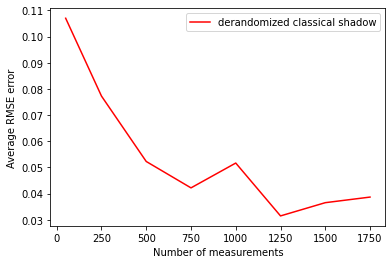

In [3]:
import matplotlib.pyplot as plt 
points = [50, 250, 500, 750, 1000, 1250, 1500, 1750] 
num_points = len(points)
rmse_errors = [0.1069869635064184, 0.07725001066018326, 0.05225116371481676, 0.042165636875291464, 
              0.051653435360326294, 0.03145057406737202, 0.03650841505283894, 0.03864886899799828]

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='derandomized classical shadow')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)